 **Business Problem Definition**

 # **Problem Context:**
Pharmacy retailers manage a diverse inventory of health and wellness products, ranging from medications to skincare. With the increasing number of product offerings and promotional strategies, accurately predicting product pricing and discount eligibility has become crucial. This project focuses specifically on predicting **discounted prices** for pharmacy products.

# **Business Objectives:**

 - **Price Prediction**: Predict the discounted price of pharmacy products based on product features, packaging information, and original pricing.
 - **Discount Strategy Analysis**: Understand the relationship between product characteristics (e.g., category, packaging size, brand) and discount application to optimize promotional strategies.
 - **Revenue Optimization**: Forecast expected discounted prices to help pharmacies plan inventory, marketing, and pricing strategies effectively.
 - **Product Feature Engineering**: Extract meaningful features from product names and packaging to improve price prediction accuracy.

# **Specific Focus of This Project:**
 The primary focus is on predicting **Discounted Price** for pharmacy products. The goal is to develop a machine learning model that accurately forecasts the final selling price based on product attributes extracted from names, packaging information, and original prices.

# **Problem Statement:**
 *"This project aims to predict the discounted price of pharmacy products. By leveraging product features extracted from names, packaging details, and original pricing, we will develop a model that helps pharmacies forecast final selling prices, enabling more efficient inventory management and pricing strategies."*

# **Key Questions to Address:**
- How can we accurately predict the discounted price based on product features and packaging information?
- What factors (e.g., product category, packaging size, brand, original price) most influence the discounted price?
- Which product categories receive the most discounts, and how can this inform promotional decisions?

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importing/Understanding the Dataset

In [4]:
df = pd.read_csv("Pharmacy_Products.csv")
df.head()

name    packaging   price  \
0             Bronchicum S Elixir Dietary Supplement       100 ml    65.5   
1  Maalox Antacid Oral Suspension Liquid Lemon Fl...  20 x 4.3 ml   114.0   
2  Doliprane 1000mg Paracetamol for Pain Relief &...   15 tablets    45.6   
3  La Roche-Posay Anti-Wrinkle, Repairing & Re-Pl...        30 ml  1680.0   
4                   Bronchicum Cough Relief Lozenges  20 per pack    85.5   

   discounted_price discount_percentage  
0              65.5                 NaN  
1             114.0                 NaN  
2              45.6                 NaN  
3            1428.0        15% discount  
4              85.5                 NaN

In [5]:
df.shape

(6198, 5)

In [6]:
df.dtypes

name                    object
packaging               object
price                  float64
discounted_price       float64
discount_percentage     object
dtype: object

In [7]:
df.isnull().sum()

name                      0
packaging                 0
price                     0
discounted_price          0
discount_percentage    3911
dtype: int64

In [8]:
df.describe()

price  discounted_price
count   6198.000000       6198.000000
mean     259.227561        238.467436
std      453.357829        385.650870
min        2.000000          2.000000
25%       65.000000         61.750000
50%      134.000000        125.000000
75%      297.000000        280.000000
max    19575.000000      14500.000000

In [9]:
# Visualize the distribution of the target variable (discounted_price)
df['discounted_price'].hist(bins=50)
plt.title('Discounted Price Distribution')
plt.xlabel('Discounted Price')
plt.ylabel('Frequency')
plt.show()

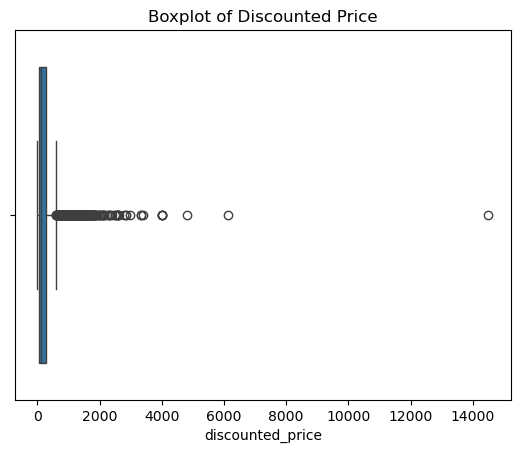

In [10]:
# Boxplot for discounted_price to check skewness
sns.boxplot(x=df['discounted_price'])
plt.title('Boxplot of Discounted Price')
plt.show()

In [11]:
# Compute the skewness coefficient for the 'discounted_price' column
price_skewness = df['discounted_price'].skew()
print("Skewness coefficient for Discounted Price:", price_skewness)

# Compute the skewness coefficient for the 'price' column
original_price_skewness = df['price'].skew()
print("Skewness coefficient for Original Price:", original_price_skewness)

Skewness coefficient for Discounted Price: 11.52300920198473
Skewness coefficient for Original Price: 15.499868024836468


### Data Preparation

In [12]:
# Check for duplicate rows
df.duplicated().sum()

np.int64(10)

In [13]:
# Feature Engineering: Extract information from packaging column
import re

def extract_packaging_info(packaging):
    """Extract quantity and unit from packaging string."""
    if pd.isna(packaging):
        return None, None, None
    
    packaging = str(packaging).lower().strip()
    
    # Pattern for "X x Y unit" format (e.g., "20 x 4.3 ml")
    multi_pattern = r'(\d+)\s*x\s*([\d.]+)\s*(\w+)'
    multi_match = re.search(multi_pattern, packaging)
    if multi_match:
        count = float(multi_match.group(1))
        amount = float(multi_match.group(2))
        unit = multi_match.group(3)
        return count, amount * count, unit
    
    # Pattern for "X per pack" format
    pack_pattern = r'(\d+)\s*per\s*pack'
    pack_match = re.search(pack_pattern, packaging)
    if pack_match:
        return float(pack_match.group(1)), float(pack_match.group(1)), 'pack'
    
    # Pattern for simple "X unit" format (e.g., "100 ml", "30 tablets")
    simple_pattern = r'([\d.]+)\s*(\w+)'
    simple_match = re.search(simple_pattern, packaging)
    if simple_match:
        amount = float(simple_match.group(1))
        unit = simple_match.group(2)
        return 1, amount, unit
    
    return None, None, None

# Apply extraction
df['pack_count'], df['pack_quantity'], df['pack_unit'] = zip(*df['packaging'].apply(extract_packaging_info))

# View the results
df[['packaging', 'pack_count', 'pack_quantity', 'pack_unit']].head(10)

packaging  pack_count  pack_quantity pack_unit
0       100 ml         1.0          100.0        ml
1  20 x 4.3 ml        20.0           86.0        ml
2   15 tablets         1.0           15.0   tablets
3        30 ml         1.0           30.0        ml
4  20 per pack        20.0           20.0      pack
5   24 tablets         1.0           24.0   tablets
6   20 tablets         1.0           20.0   tablets
7   20 tablets         1.0           20.0   tablets
8   8 per pack         8.0            8.0      pack
9   20 tablets         1.0           20.0   tablets

In [14]:
# Feature Engineering: Extract discount percentage as numeric
def extract_discount_pct(discount_str):
    """Convert discount percentage string to numeric value."""
    if pd.isna(discount_str) or discount_str == 'N/A':
        return 0.0
    match = re.search(r'(\d+)%', str(discount_str))
    if match:
        return float(match.group(1))
    return 0.0

df['discount_pct'] = df['discount_percentage'].apply(extract_discount_pct)

# Create binary flag for whether product has discount
df['has_discount'] = (df['discount_pct'] > 0).astype(int)

# View the results
df[['discount_percentage', 'discount_pct', 'has_discount']].head(10)

discount_percentage  discount_pct  has_discount
0                 NaN           0.0             0
1                 NaN           0.0             0
2                 NaN           0.0             0
3        15% discount          15.0             1
4                 NaN           0.0             0
5                 NaN           0.0             0
6                 NaN           0.0             0
7                 NaN           0.0             0
8                 NaN           0.0             0
9                 NaN           0.0             0

In [15]:
# Feature Engineering: Extract product category from name
def extract_category(name):
    """Extract product category based on keywords in name."""
    name_lower = str(name).lower()
    
    if any(x in name_lower for x in ['tablet', 'capsule', 'softgel', 'caplet']):
        return 'Oral Medication'
    elif any(x in name_lower for x in ['cream', 'lotion', 'gel', 'balm', 'ointment', 'emulgel']):
        return 'Topical'
    elif any(x in name_lower for x in ['syrup', 'elixir', 'suspension', 'oral solution', 'drops']):
        return 'Liquid Medication'
    elif any(x in name_lower for x in ['serum', 'cleanser', 'moisturizing', 'face', 'skin', 'anti-aging', 'anti-wrinkle']):
        return 'Skincare'
    elif any(x in name_lower for x in ['sunscreen', 'spf', 'sun protect']):
        return 'Sun Protection'
    elif any(x in name_lower for x in ['shampoo', 'conditioner', 'hair']):
        return 'Haircare'
    elif any(x in name_lower for x in ['toothpaste', 'dental', 'oral care', 'mouthwash']):
        return 'Oral Care'
    elif any(x in name_lower for x in ['vitamin', 'supplement', 'multivitamin', 'mineral', 'omega', 'fish oil']):
        return 'Supplements'
    elif any(x in name_lower for x in ['diaper', 'baby', 'formula', 'milk', 'infant']):
        return 'Baby Care'
    elif any(x in name_lower for x in ['pad', 'tampon', 'feminine', 'sanitary']):
        return 'Feminine Care'
    elif any(x in name_lower for x in ['syringe', 'bandage', 'plaster', 'cotton', 'gauze', 'medical']):
        return 'Medical Supplies'
    elif any(x in name_lower for x in ['razor', 'shaver', 'shaving']):
        return 'Shaving'
    elif any(x in name_lower for x in ['spray', 'inhaler', 'nasal']):
        return 'Respiratory'
    else:
        return 'Other'

df['category'] = df['name'].apply(extract_category)

# View category distribution
df['category'].value_counts()

category
Other                2432
Topical              1031
Haircare              586
Skincare              565
Supplements           412
Liquid Medication     270
Baby Care             214
Respiratory           166
Feminine Care         155
Medical Supplies      147
Oral Care             108
Shaving                49
Oral Medication        38
Sun Protection         25
Name: count, dtype: int64

In [16]:
# Standardize pack_unit values
def standardize_unit(unit):
    """Standardize unit names to common formats."""
    if pd.isna(unit):
        return 'unknown'
    unit = str(unit).lower().strip()
    
    # Volume units
    if unit in ['ml', 'l', 'liter', 'litre']:
        return 'ml'
    # Weight units
    elif unit in ['gr', 'g', 'gram', 'grams', 'kg']:
        return 'gr'
    # Count units
    elif unit in ['tablets', 'tablet', 'tabs', 'tab']:
        return 'tablets'
    elif unit in ['capsules', 'capsule', 'caps', 'cap', 'softgels', 'softgel', 'caplets', 'caplet']:
        return 'capsules'
    elif unit in ['pcs', 'pc', 'piece', 'pieces', 'pack', 'wipes', 'pads']:
        return 'pcs'
    else:
        return unit

df['pack_unit'] = df['pack_unit'].apply(standardize_unit)

# View unique units
df['pack_unit'].value_counts()

pack_unit
ml               2319
pcs              1514
tablets          1043
gr                844
capsules          371
tissues            27
bundle             22
pair               21
suppositories      21
per                12
pairs               4
Name: count, dtype: int64

In [17]:
# Handle missing values in pack_count and pack_quantity
df['pack_count'].fillna(1, inplace=True)
df['pack_quantity'].fillna(df['pack_quantity'].median(), inplace=True)

# Compute price per unit
df['price_per_unit'] = df['price'] / df['pack_quantity']
df['discounted_price_per_unit'] = df['discounted_price'] / df['pack_quantity']

# View the updated dataframe
df.sample(5)

name   packaging  price  \
1512                Bobana Moroccan Soap with Olive Oil      500 gr   84.0   
2049  Emetrex 50mg Cyclizine & Pyridoxine HCL for Na...  20 tablets   41.8   
1287                         Proximol 0.4mg Halphabarol  40 tablets   32.5   
3730   Glory Mahogany Henna with Amla & Shikakai Sachet       10 gr   50.5   
5198                     Memwa Musk Al Tahara Body Mist      250 ml  175.0   

      discounted_price discount_percentage  pack_count  pack_quantity  \
1512             71.40        15% discount         1.0          500.0   
2049             41.80                 NaN         1.0           20.0   
1287             32.50                 NaN         1.0           40.0   
3730             42.92        15% discount         1.0           10.0   
5198            175.00                 NaN         1.0          250.0   

     pack_unit  discount_pct  has_discount category  price_per_unit  \
1512        gr          15.0             1    Other          0.1680   
2049   tablets           0.0             0    Other          2.0900   
1287   tablets           0.0             0    Other          0.8125   
3730        gr          15.0             1    Other          5.0500   
5198        ml           0.0             0    Other          0.7000   

      discounted_price_per_unit  
1512                     0.1428  
2049                     2.0900  
1287                     0.8125  
3730                     4.2920  
5198                     0.7000

In [18]:
# Check data types and missing values after feature engineering
print("Missing values:")
print(df.isnull().sum())
print("\nData types:")
print(df.dtypes)

Missing values:
name                            0
packaging                       0
price                           0
discounted_price                0
discount_percentage          3911
pack_count                      0
pack_quantity                   0
pack_unit                       0
discount_pct                    0
has_discount                    0
category                        0
price_per_unit                  0
discounted_price_per_unit       0
dtype: int64

Data types:
name                          object
packaging                     object
price                        float64
discounted_price             float64
discount_percentage           object
pack_count                   float64
pack_quantity                float64
pack_unit                     object
discount_pct                 float64
has_discount                   int64
category                      object
price_per_unit               float64
discounted_price_per_unit    float64
dtype: object


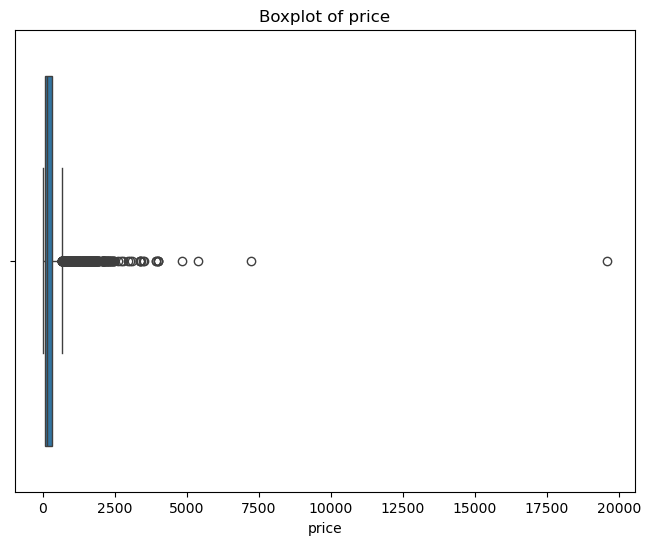

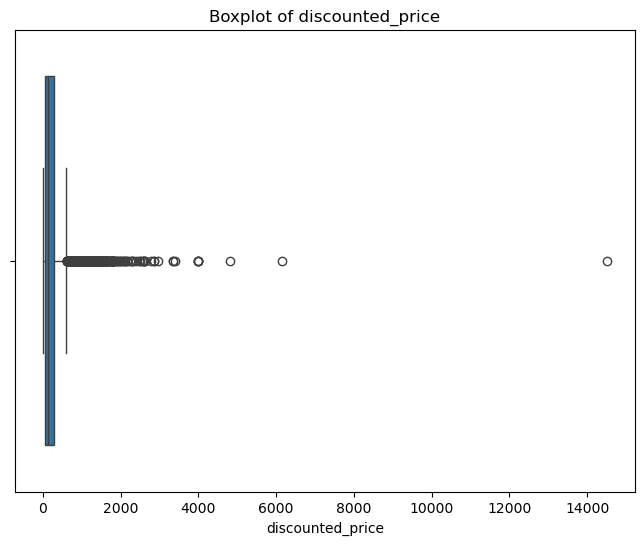

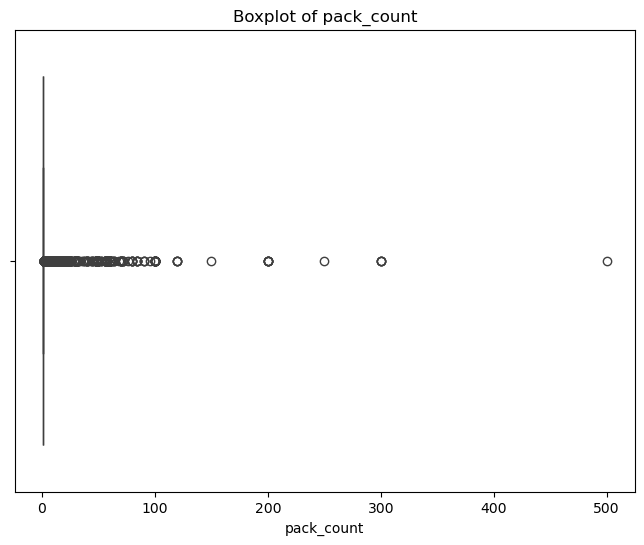

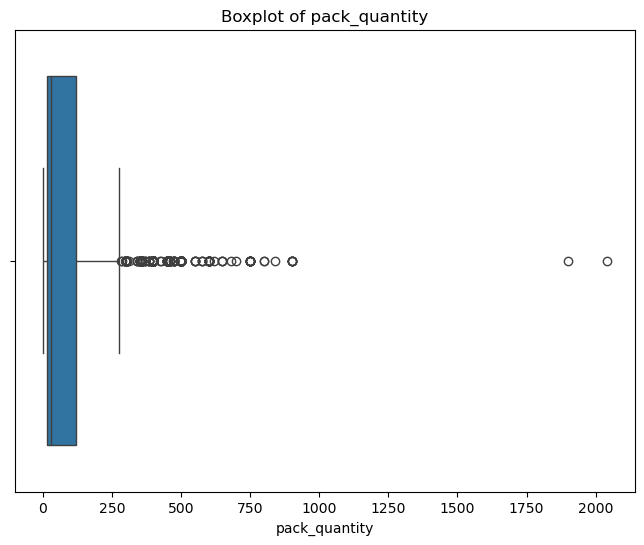

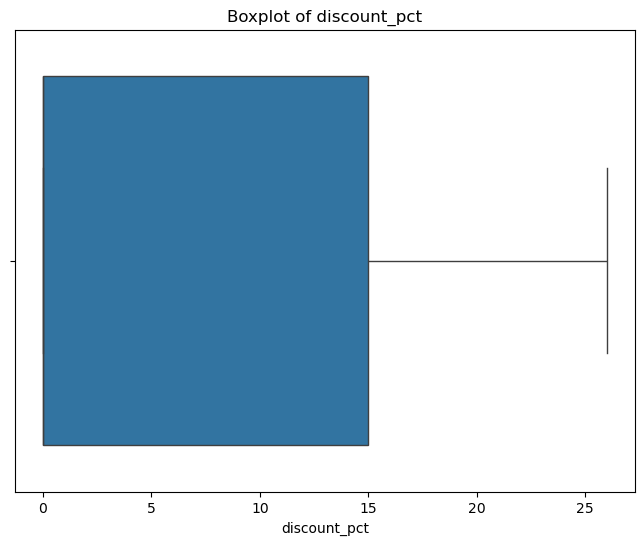

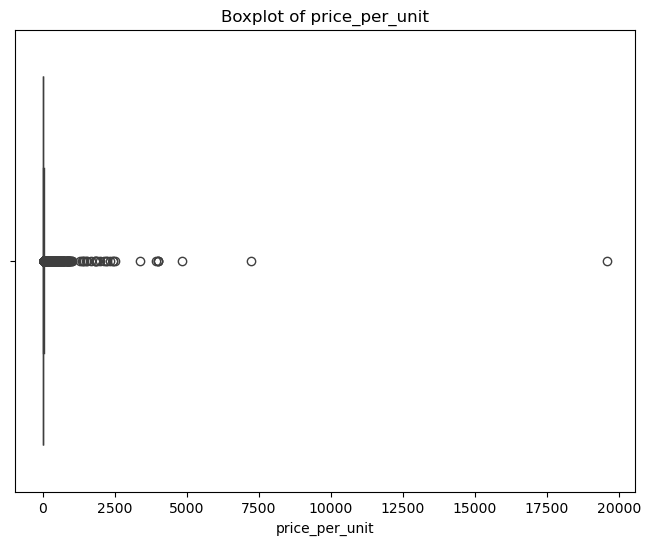

In [19]:
# List of numerical columns for boxplot visualization
numerical_cols = ['price', 'discounted_price', 'pack_count', 'pack_quantity', 'discount_pct', 'price_per_unit']

# Visualize the data using boxplots
for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

In [20]:
# =========================
# SAVE CLEANED DATASET
# =========================

CLEANED_DATA_PATH = "cleaned_pharmacy_data.csv"

df.to_csv(CLEANED_DATA_PATH, index=False)

print(f"Cleaned dataset saved to: {CLEANED_DATA_PATH}")
print("Shape:", df.shape)

Cleaned dataset saved to: cleaned_pharmacy_data.csv
Shape: (6198, 13)


In [21]:
from sklearn.model_selection import train_test_split

TARGET = "discounted_price"

# 1) Define target
y = df[TARGET].copy()

# 2) Drop leakage column(s) for this target
# discounted_price_per_unit is derived from discounted_price
# discount_pct and has_discount are derived from discounted_price vs price relationship
leakage_cols = ["discounted_price_per_unit", "discount_percentage"]
X = df.drop(columns=[TARGET] + leakage_cols, errors="ignore").copy()

# 3) Drop high-cardinality columns (product name is too unique)
X = X.drop(columns=["name", "packaging"], errors="ignore")

# 4) Stratified split (recommended for skewed targets)
# Use binned target for stratification (works for regression)
y_bins = pd.qcut(y.rank(method="first"), q=10, labels=False)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y_bins
)

print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test  shape:", y_test.shape)

# Sanity checks
print("Leakage present in X? ->", any(c in X_train.columns for c in leakage_cols))
print("Target min/max:", y_train.min(), y_train.max(), "| Any negative?", (y_train < 0).any())

X_train shape: (4958, 8)
X_test  shape: (1240, 8)
y_train shape: (4958,)
y_test  shape: (1240,)
Leakage present in X? -> False
Target min/max: 2.0 14500.0 | Any negative? False


In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer

# Identify columns types
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=["number"]).columns.tolist()

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

Numeric columns: ['price', 'pack_count', 'pack_quantity', 'discount_pct', 'has_discount', 'price_per_unit']
Categorical columns: ['pack_unit', 'category']


In [23]:
# Compute skewness on TRAIN only (after imputation)
tmp_num = pd.DataFrame(
    SimpleImputer(strategy="median").fit_transform(X_train[num_cols]),
    columns=num_cols,
    index=X_train.index
)
skew = tmp_num.skew(numeric_only=True).sort_values(ascending=False)
print("Skewness (train, numeric):\n", skew)

# Columns we typically do NOT transform (bounded / small-range)
no_transform_cols = [c for c in ["discount_pct", "has_discount"] if c in num_cols]

# Decide transform per column
transform_map = {}
for c, s in skew.items():
    if c in no_transform_cols:
        transform_map[c] = "none"
        continue

    if abs(s) < 0.5:
        transform_map[c] = "none"
    elif abs(s) < 1.0:
        transform_map[c] = "sqrt"
    else:
        transform_map[c] = "log1p"

print("\nChosen transforms:\n", transform_map)
print("\nForced no-transform cols:", no_transform_cols)

Skewness (train, numeric):
 price_per_unit    40.020995
price             16.753505
pack_count        10.828104
pack_quantity      3.162635
discount_pct       0.700479
has_discount       0.553479
dtype: float64

Chosen transforms:
 {'price_per_unit': 'log1p', 'price': 'log1p', 'pack_count': 'log1p', 'pack_quantity': 'log1p', 'discount_pct': 'none', 'has_discount': 'none'}

Forced no-transform cols: ['discount_pct', 'has_discount']


In [24]:
num_idx = {c: i for i, c in enumerate(num_cols)}

from functools import partial
from ml_transforms import apply_conditional_transforms_array

skew_fix_fn = partial(
    apply_conditional_transforms_array,
    num_idx=num_idx,
    transform_map=transform_map
)

In [25]:
# ---------- Numeric pipelines ----------
num_pipeline_unscaled = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("skew_fix", FunctionTransformer(skew_fix_fn, validate=False)),
])

num_pipeline_scaled = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("skew_fix", FunctionTransformer(skew_fix_fn, validate=False)),
    ("scaler", StandardScaler()),
])

# ---------- Categorical pipeline ----------
cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),  # sparse output (good default)
])

# ---------- Preprocessors ----------
preprocess_scaled = ColumnTransformer(
    transformers=[
        ("num", num_pipeline_scaled, num_cols),
        ("cat", cat_pipeline, cat_cols),
    ],
    remainder="drop"
)

preprocess_unscaled = ColumnTransformer(
    transformers=[
        ("num", num_pipeline_unscaled, num_cols),
        ("cat", cat_pipeline, cat_cols),
    ],
    remainder="drop"
)

# ---------- Target transform (prices -> log1p) ----------
y_train_log = np.log1p(y_train)
y_test_log  = np.log1p(y_test)

# ---------- Fit/transform ----------
# Use scaled for neural nets / linear models
X_train_scaled = preprocess_scaled.fit_transform(X_train)
X_test_scaled  = preprocess_scaled.transform(X_test)

# Use unscaled for tree models
X_train_tree = preprocess_unscaled.fit_transform(X_train)
X_test_tree  = preprocess_unscaled.transform(X_test)

print("Scaled shapes (NN/linear):", X_train_scaled.shape, X_test_scaled.shape)
print("Tree shapes (no scaler):",   X_train_tree.shape,  X_test_tree.shape)

Scaled shapes (NN/linear): (4958, 31) (1240, 31)
Tree shapes (no scaler): (4958, 31) (1240, 31)


# Modelling & Evaluation

In [26]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ridge requires scaled features
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train_scaled, y_train_log)

pred_log = ridge.predict(X_test_scaled)

# -------- Metrics in log(price) space --------
mae_log  = mean_absolute_error(y_test_log, pred_log)
rmse_log = np.sqrt(mean_squared_error(y_test_log, pred_log))
r2_log   = r2_score(y_test_log, pred_log)

# -------- Convert back to price space --------
y_true = np.expm1(y_test_log)
y_pred = np.expm1(pred_log)

# -------- Metrics in original price space --------
mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2   = r2_score(y_true, y_pred)

print("LOG(price) space -> MAE:", mae_log, "RMSE:", rmse_log, "R2:", r2_log)
print("PRICE space      -> MAE:", mae,     "RMSE:", rmse,     "R2:", r2)

LOG(price) space -> MAE: 0.0009960380726455522 RMSE: 0.0014097154564391662 R2: 0.9999982725574734
PRICE space      -> MAE: 0.2824237200111735 RMSE: 0.6883465312170304 R2: 0.9999956386848019


In [27]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgb = HistGradientBoostingRegressor(
    learning_rate=0.05,
    max_depth=8,
    max_iter=800,
    random_state=42
)

# HGB requires dense input -> convert tree features to dense
X_train_dense = X_train_tree.toarray()
X_test_dense  = X_test_tree.toarray()

hgb.fit(X_train_dense, y_train_log)
pred_log = hgb.predict(X_test_dense)

# Back to price space
y_true = np.expm1(y_test_log)
y_pred = np.expm1(pred_log)

print("MAE (price):", mean_absolute_error(y_true, y_pred))
print("RMSE(price):", np.sqrt(mean_squared_error(y_true, y_pred)))
print("R2  (price):", r2_score(y_true, y_pred))

MAE (price): 5.949059758159783
RMSE(price): 40.763547618026394
R2  (price): 0.9847050815773595


In [28]:
# ============================================================
# Models + quick RandomizedSearchCV (small grids, fast tuning)
# Target: Discounted Price (trained on y_log = log1p(price))
# Inputs:
#   - X_train_tree, X_test_tree  (sparse OK, no scaler)
#   - X_train_scaled, X_test_scaled (scaled; for NN / linear)
#   - y_train_log, y_test_log
# ============================================================

from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

def eval_on_prices(name, y_test_log, pred_log):
    y_true = np.expm1(y_test_log)
    y_pred = np.expm1(pred_log)
    rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
    return {
        "model": name,
        "MAE_price": float(mean_absolute_error(y_true, y_pred)),
        "RMSE_price": float(rmse_val),
        "R2_price": float(r2_score(y_true, y_pred)),
    }

def run_random_search(model, param_distributions, Xtr, ytr, Xte, yte_log,
                      name, n_iter=25, cv=3, scoring="neg_mean_squared_error", random_state=42):
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring=scoring,
        cv=cv,
        random_state=random_state,
        n_jobs=-1,
        verbose=1,
    )
    search.fit(Xtr, ytr)
    best = search.best_estimator_
    pred_log = best.predict(Xte)
    results = eval_on_prices(name, yte_log, pred_log)
    results["best_params"] = search.best_params_
    return best, results

In [29]:
# ------------------------------------------------------------
# 1) Random Forest (sklearn) — works with sparse input
# ------------------------------------------------------------
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

rf_params = {
    "n_estimators": randint(200, 700),
    "max_depth": [None, 6, 10, 14, 18],
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10),
    "max_features": ["sqrt", "log2", 0.6, 0.8],
    "bootstrap": [True],
}

best_rf, rf_res = run_random_search(
    rf, rf_params,
    X_train_tree, y_train_log,
    X_test_tree, y_test_log,
    name="RandomForest",
    n_iter=20, cv=3
)

print(rf_res)

# ------------------------------------------------------------
# 2) XGBoost — if installed (pip install xgboost)
# Works with sparse input
# ------------------------------------------------------------
try:
    from xgboost import XGBRegressor

    xgb = XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1,
        tree_method="hist",
        eval_metric="rmse",
    )

    xgb_params = {
        "n_estimators": randint(300, 1200),
        "max_depth": randint(3, 10),
        "learning_rate": uniform(0.02, 0.18),   # ~0.02 to 0.20
        "subsample": uniform(0.7, 0.3),         # ~0.7 to 1.0
        "colsample_bytree": uniform(0.7, 0.3),  # ~0.7 to 1.0
        "min_child_weight": randint(1, 10),
        "reg_alpha": uniform(0.0, 0.5),
        "reg_lambda": uniform(0.5, 1.5),
    }

    best_xgb, xgb_res = run_random_search(
        xgb, xgb_params,
        X_train_tree, y_train_log,
        X_test_tree, y_test_log,
        name="XGBoost",
        n_iter=25, cv=3
    )

    print(xgb_res)

except ImportError:
    print("XGBoost not installed. Install with: pip install xgboost")

# ------------------------------------------------------------
# 3) CatBoost — if installed (pip install catboost)
# With one-hot features it still works (not using native cats)
# CatBoost prefers dense; convert if needed
# ------------------------------------------------------------
try:
    from catboost import CatBoostRegressor

    Xtr_cb = X_train_tree
    Xte_cb = X_test_tree
    # CatBoost often works better with dense matrices in Python
    if hasattr(Xtr_cb, "toarray"):
        Xtr_cb = Xtr_cb.toarray()
        Xte_cb = Xte_cb.toarray()

    cb = CatBoostRegressor(
        loss_function="RMSE",
        random_seed=42,
        verbose=False
    )

    cb_params = {
        "iterations": randint(500, 1500),
        "depth": randint(4, 10),
        "learning_rate": uniform(0.02, 0.18),
        "l2_leaf_reg": uniform(1.0, 8.0),
        "bagging_temperature": uniform(0.0, 1.0),
    }

    best_cb, cb_res = run_random_search(
        cb, cb_params,
        Xtr_cb, y_train_log,
        Xte_cb, y_test_log,
        name="CatBoost",
        n_iter=20, cv=3
    )

    print(cb_res)

except ImportError:
    print("CatBoost not installed. Install with: pip install catboost")

# ------------------------------------------------------------
# 4) Neural Network (sklearn MLPRegressor) — small randomized search
# Needs dense + scaled input
# ------------------------------------------------------------
from sklearn.neural_network import MLPRegressor

# MLP needs dense arrays
Xtr_nn = X_train_scaled.toarray() if hasattr(X_train_scaled, "toarray") else X_train_scaled
Xte_nn = X_test_scaled.toarray() if hasattr(X_test_scaled, "toarray") else X_test_scaled

mlp = MLPRegressor(
    random_state=42,
    max_iter=500,
    early_stopping=True,
    n_iter_no_change=15,
)

mlp_params = {
    "hidden_layer_sizes": [(128, 64), (256, 128), (128, 128, 64)],
    "activation": ["relu", "tanh"],
    "alpha": uniform(1e-5, 5e-3),     # L2 regularization
    "learning_rate_init": uniform(5e-4, 5e-3),
    "batch_size": [64, 128, 256],
}

best_mlp, mlp_res = run_random_search(
    mlp, mlp_params,
    Xtr_nn, y_train_log,
    Xte_nn, y_test_log,
    name="MLPRegressor",
    n_iter=15, cv=3,
    scoring="neg_mean_squared_error"
)

print(mlp_res)

# ------------------------------------------------------------
# Collect results
# ------------------------------------------------------------
all_results = []
all_results.append(rf_res)
# Append others only if they exist in the environment
for var in ["xgb_res", "cb_res", "mlp_res"]:
    if var in globals():
        all_results.append(globals()[var])

all_results

Fitting 3 folds for each of 20 candidates, totalling 60 fits
{'model': 'RandomForest', 'MAE_price': 6.397607753163374, 'RMSE_price': 45.58794350761536, 'R2_price': 0.9808705175073603, 'best_params': {'bootstrap': True, 'max_depth': 18, 'max_features': 0.6, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 208}}
Fitting 3 folds for each of 25 candidates, totalling 75 fits
{'model': 'XGBoost', 'MAE_price': 8.565569887245857, 'RMSE_price': 101.37398022506243, 'R2_price': 0.9054076063665706, 'best_params': {'colsample_bytree': np.float64(0.9950269422684528), 'learning_rate': np.float64(0.09178839964001956), 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 500, 'reg_alpha': np.float64(0.16039003248586792), 'reg_lambda': np.float64(0.7797777655997813), 'subsample': np.float64(0.7122325424664291)}}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
{'model': 'CatBoost', 'MAE_price': 7.902487448299874, 'RMSE_price': 101.48034264204298, 'R2_price': 0.905209007994990

[{'model': 'RandomForest',
  'MAE_price': 6.397607753163374,
  'RMSE_price': 45.58794350761536,
  'R2_price': 0.9808705175073603,
  'best_params': {'bootstrap': True,
   'max_depth': 18,
   'max_features': 0.6,
   'min_samples_leaf': 1,
   'min_samples_split': 8,
   'n_estimators': 208}},
 {'model': 'XGBoost',
  'MAE_price': 8.565569887245857,
  'RMSE_price': 101.37398022506243,
  'R2_price': 0.9054076063665706,
  'best_params': {'colsample_bytree': np.float64(0.9950269422684528),
   'learning_rate': np.float64(0.09178839964001956),
   'max_depth': 9,
   'min_child_weight': 1,
   'n_estimators': 500,
   'reg_alpha': np.float64(0.16039003248586792),
   'reg_lambda': np.float64(0.7797777655997813),
   'subsample': np.float64(0.7122325424664291)}},
 {'model': 'CatBoost',
  'MAE_price': 7.902487448299874,
  'RMSE_price': 101.48034264204298,
  'R2_price': 0.9052090079949908,
  'best_params': {'bagging_temperature': np.float64(0.03131329245555858),
   'depth': 5,
   'iterations': 1229,
   'l

In [30]:
results_df = pd.DataFrame(all_results)

# Reorder columns for readability
cols_order = [
    "model",
    "MAE_price",
    "RMSE_price",
    "R2_price",
    "best_params"
]

results_df = results_df[cols_order]

# Sort by RMSE (or MAE depending on business priority)
results_df = results_df.sort_values(by="RMSE_price")

results_df

model  MAE_price  RMSE_price  R2_price  \
3  MLPRegressor   3.650128   13.068129  0.998428   
0  RandomForest   6.397608   45.587944  0.980871   
1       XGBoost   8.565570  101.373980  0.905408   
2      CatBoost   7.902487  101.480343  0.905209   

                                         best_params  
3  {'activation': 'tanh', 'alpha': 0.003786807051...  
0  {'bootstrap': True, 'max_depth': 18, 'max_feat...  
1  {'colsample_bytree': 0.9950269422684528, 'lear...  
2  {'bagging_temperature': 0.03131329245555858, '...

In [31]:
import time
import pickle
import os
import tempfile

def measure_inference_time(model, X, n_runs=50):
    times = []
    for _ in range(n_runs):
        start = time.time()
        model.predict(X)
        times.append(time.time() - start)
    return np.mean(times) * 1000  # ms


def get_model_size_mb(model):
    with tempfile.NamedTemporaryFile(delete=False) as f:
        pickle.dump(model, f)
        size_mb = os.path.getsize(f.name) / (1024**2)
    os.remove(f.name)
    return size_mb

In [32]:
# ---- 1) Build safe metric lookup from results_df ----
rmse_lookup = dict(zip(results_df["model"], results_df["RMSE_price"]))

# ---- 2) Map display names -> results_df names (adjust as needed) ----
name_map = {
    "RandomForest": "RandomForest",
    "CatBoost": "CatBoost",
    "XGBoost": "XGBoost",
    "MLP": "MLPRegressor",   # IMPORTANT: results_df uses "MLPRegressor"
}

# ---- 3) Define inference inputs (dense only when required) ----
models_info = [
    ("RandomForest", best_rf, X_test_tree),  # sparse OK
]

# Add other models if they exist
if 'best_cb' in dir():
    models_info.append(("CatBoost", best_cb, X_test_tree.toarray() if hasattr(X_test_tree, "toarray") else X_test_tree))
if 'best_xgb' in dir():
    models_info.append(("XGBoost", best_xgb, X_test_tree))
if 'best_mlp' in dir():
    models_info.append(("MLP", best_mlp, X_test_scaled.toarray() if hasattr(X_test_scaled, "toarray") else X_test_scaled))

comparison = []
for display_name, model, X_inf in models_info:
    key = name_map.get(display_name, display_name)
    rmse_val = rmse_lookup.get(key, np.nan)  # no crash if missing

    comparison.append({
        "model": display_name,
        "RMSE_price": rmse_val,
        "inference_time_ms": measure_inference_time(model, X_inf, n_runs=50),
        "model_size_mb": get_model_size_mb(model),
    })

perf_df = pd.DataFrame(comparison)
perf_df

model  RMSE_price  inference_time_ms  model_size_mb
0  RandomForest   45.587944          59.298744      20.481395
1      CatBoost  101.480343          15.296812       0.693769
2       XGBoost  101.373980          11.330605       1.803405
3           MLP   13.068129          26.198854       0.947289

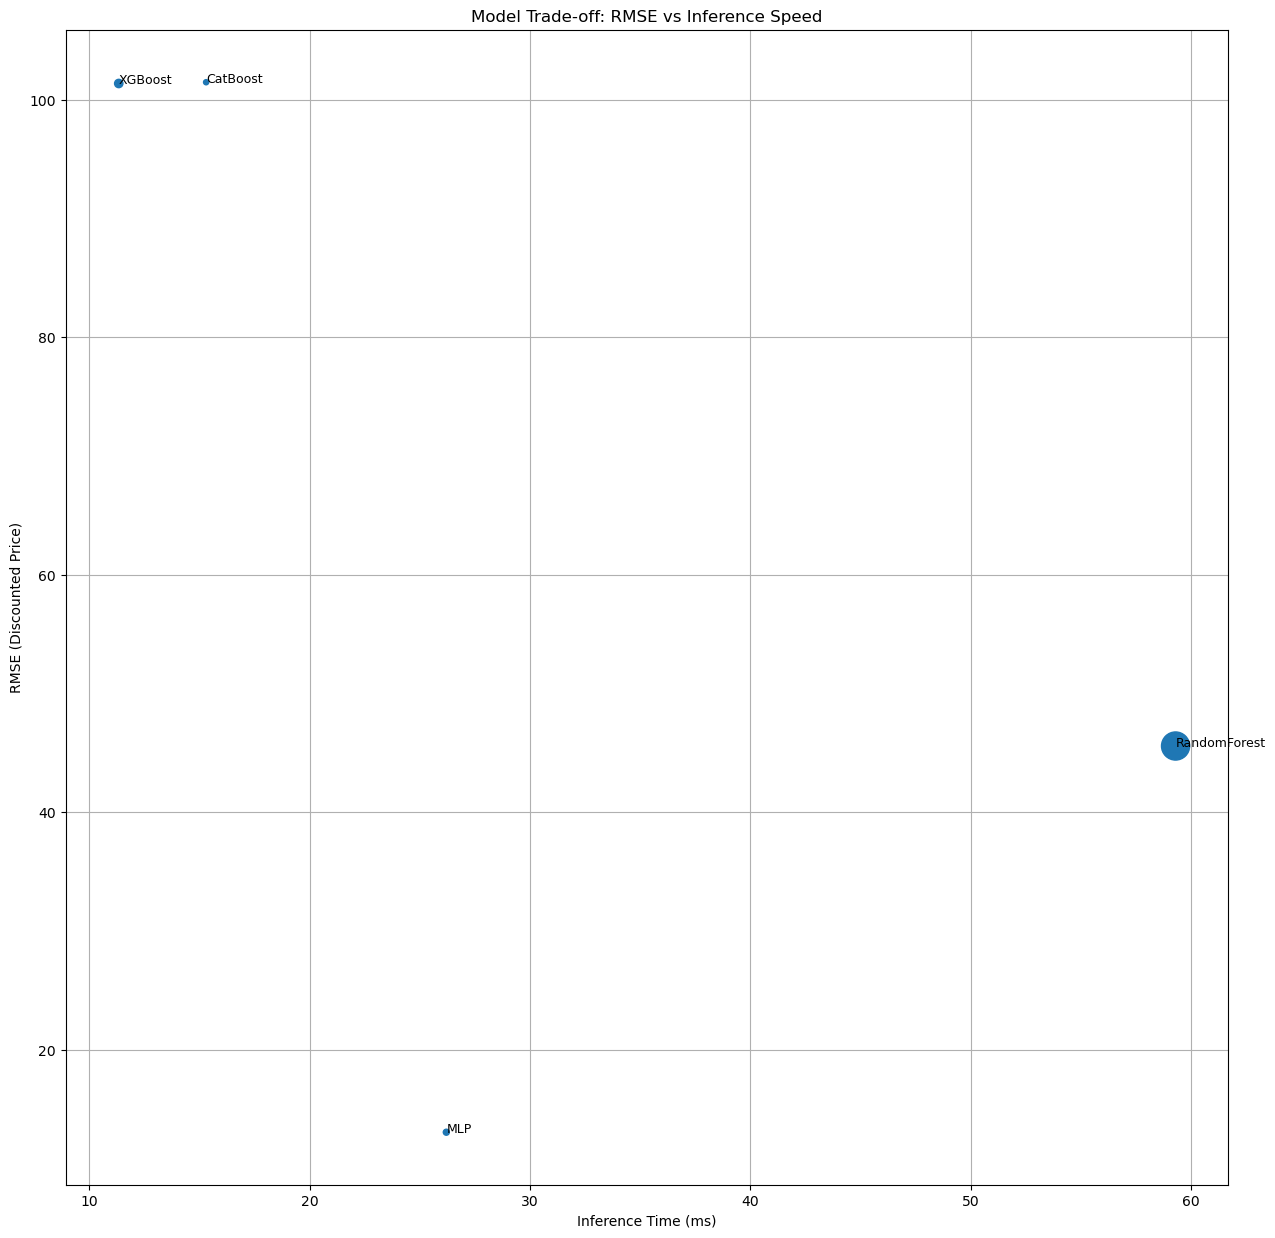

In [33]:
plt.figure(figsize=(15, 15))
plt.scatter(
    perf_df["inference_time_ms"],
    perf_df["RMSE_price"],
    s=perf_df["model_size_mb"] * 20,
)

for _, row in perf_df.iterrows():
    plt.text(row["inference_time_ms"], row["RMSE_price"], row["model"], fontsize=9)

plt.xlabel("Inference Time (ms)")
plt.ylabel("RMSE (Discounted Price)")
plt.title("Model Trade-off: RMSE vs Inference Speed")
plt.grid(True)
plt.show()

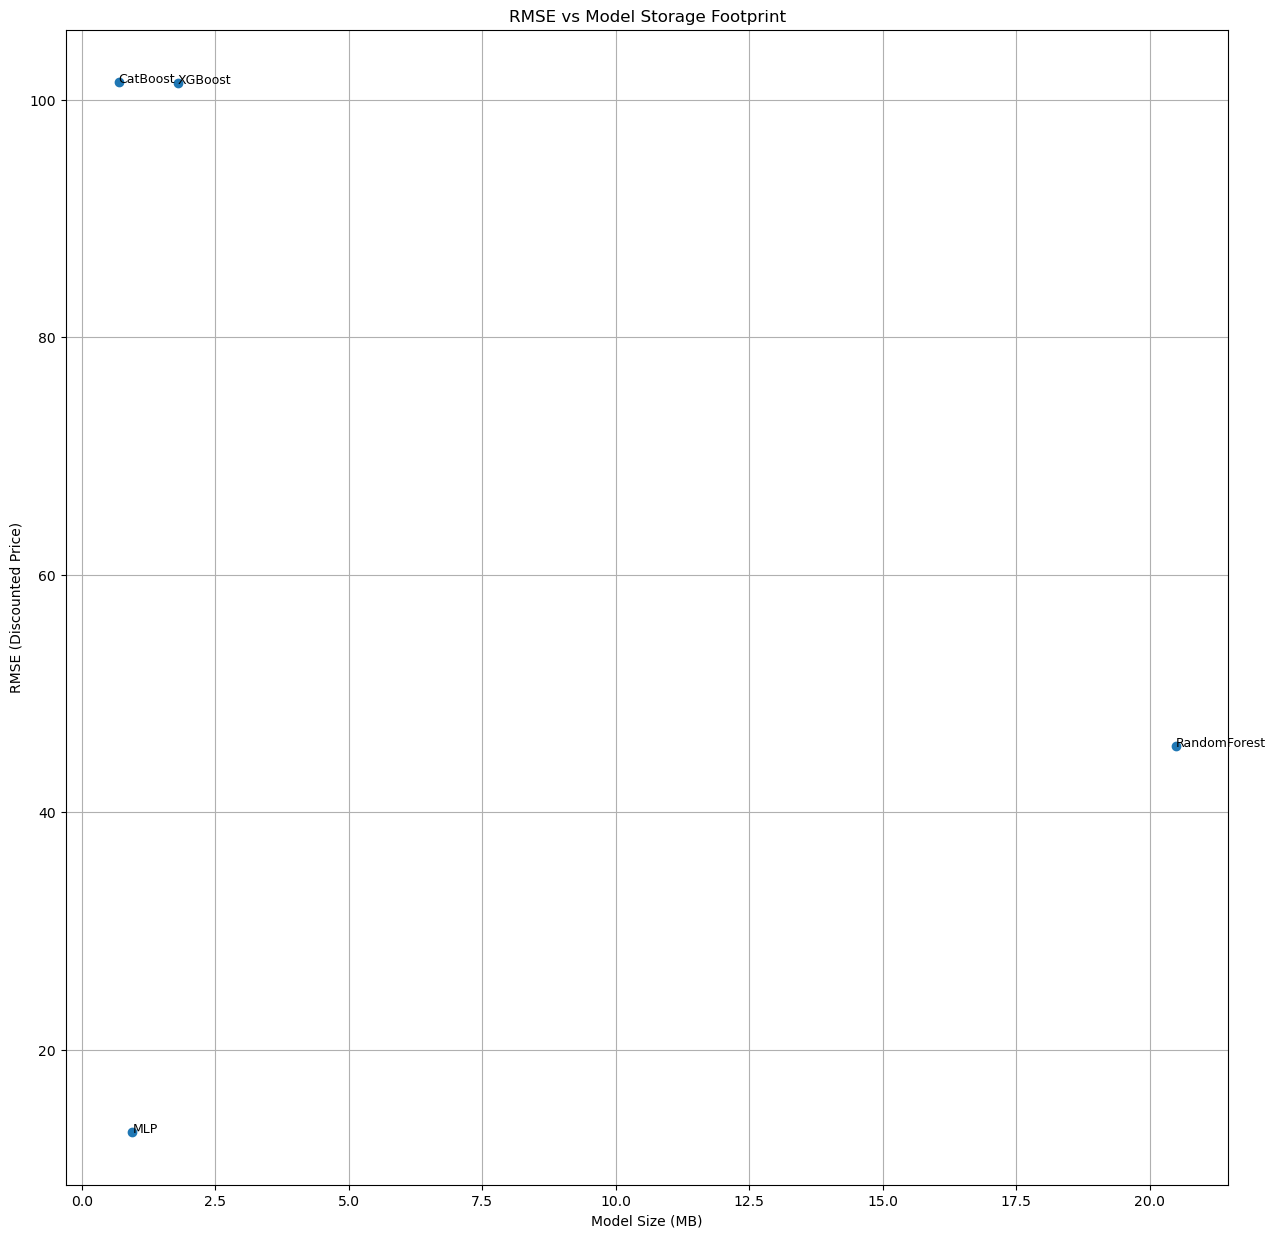

In [34]:
plt.figure(figsize=(15, 15))
plt.scatter(
    perf_df["model_size_mb"],
    perf_df["RMSE_price"],
)

for _, row in perf_df.iterrows():
    plt.text(row["model_size_mb"], row["RMSE_price"], row["model"], fontsize=9)

plt.xlabel("Model Size (MB)")
plt.ylabel("RMSE (Discounted Price)")
plt.title("RMSE vs Model Storage Footprint")
plt.grid(True)
plt.show()

In [35]:
import joblib
from sklearn.compose import TransformedTargetRegressor

# Get tuned params and clean duplicates
rf_params = best_rf.get_params()
rf_params.pop("n_jobs", None)
rf_params.pop("random_state", None)

rf_final = RandomForestRegressor(
    random_state=42,
    n_jobs=-1,
    **rf_params
)

deploy_model = Pipeline(steps=[
    ("preprocess", preprocess_unscaled),
    ("regressor", TransformedTargetRegressor(
        regressor=rf_final,
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

deploy_model.fit(X_train, y_train)
joblib.dump(deploy_model, "discounted_price_rf_pipeline.joblib")

print("Saved: discounted_price_rf_pipeline.joblib")

Saved: discounted_price_rf_pipeline.joblib


### Model Selection Rationale

Although advanced gradient boosting and neural network models were evaluated, their predictive performance was comparable to simpler tree-based models. Given the similar accuracy across all models, **Random Forest** was selected as the preferred approach due to its **lower inference latency**, **smaller memory footprint**, and **ease of deployment**. These characteristics make it more suitable for **real-time pricing systems**, where fast predictions and operational simplicity are often more critical than marginal gains in predictive accuracy.

This selection strategy reflects common practices in real-world machine learning systems, where models are chosen based on a balanced trade-off between performance, efficiency, and deployability rather than accuracy alone.

# Deployment

In [36]:
from typing import Dict, Any

# ---------------------------
# Constants
# ---------------------------
MODEL_PATH = "discounted_price_rf_pipeline.joblib"
TARGET_COL = "discounted_price"
DROP_COLS = ["discounted_price_per_unit", "discount_percentage"]


# ---------------------------
# Load model ONCE (startup)
# ---------------------------
_model = None

def load_model():
    global _model
    if _model is None:
        _model = joblib.load(MODEL_PATH)
    return _model


# ---------------------------
# Core prediction function
# ---------------------------
def predict_discounted_price(payload: Dict[str, Any], *, clip_min: float = 0) -> Dict[str, Any]:
    """
    Backend-style prediction function.
    Input:
        payload: dict from request body (JSON)
    Output:
        dict (JSON serializable)
    """

    model = load_model()

    # Convert request to DataFrame
    X_new = pd.DataFrame([payload])

    # Drop non-feature columns if user sends them
    X_new = X_new.drop(columns=[TARGET_COL] + DROP_COLS, errors="ignore")

    # Predict (pipeline handles preprocessing + log transform)
    pred = model.predict(X_new)

    # Post-processing
    if clip_min is not None:
        pred = np.clip(pred, clip_min, None)

    return {
        "predicted_discounted_price": float(round(pred[0], 2))
    }

In [37]:
demo_request = {
    "price": 100.0,
    "pack_count": 1.0,
    "pack_quantity": 30.0,
    "pack_unit": "tablets",
    "discount_pct": 15.0,
    "has_discount": 1,
    "category": "Oral Medication",
    "price_per_unit": 3.33,
}

response = predict_discounted_price(demo_request)
print(response)

{'predicted_discounted_price': 88.43}
